# We generate 2d ising configurations and train the RBM on that and with a smoother landscape:

In [1]:
import sys
import os
sys.path.append('Jerome_scripts_Original/PGM/')
sys.path.append('selfPackages/')
sys.path.append('Jerome_scripts_Original/')
sys.path.append('ffmpeg-3.4.2-32bit-static/')

import numpy as np
import scipy as sc
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

try:
    import rbm
    import bm
except:
    print 'Compiling cy_utilities first'
    curr_dir = os.getcwd()
    os.chdir('PGM/')
    !python setup.py build_ext --inplace
    print 'Compilation done'
    os.chdir(curr_dir)
    
import pickle
from ising import IsingModel
import estimate_correlations_ising
from sklearn.utils import shuffle
import inlineMovies

In [21]:
#import dill
#dill.dump_session('./data_bruckner/data/notebookData/21_ising2D_smoothLandscape')

In [4]:
import dill
dill.load_session('./data_bruckner/data/notebookData/21_ising2D_smoothLandscape')

In [20]:
#del data

In [3]:
# Save the data array with the 2d isisng model configurations: Expensive to generate over again.
#np.save('./data_bruckner/data/notebookData/data_ising2D_1million_beta0.39_size20',data)
data = np.load('./data_bruckner/data/notebookData/data_ising2D_1million_beta0.39_size20.npy')

In [16]:
beta_critical = np.log(1+2**0.5)/2
print beta_critical

0.44068679351


In [ ]:
#%%capture capt1
#Supress the output of the cell and save it to capt1

size = 20
N = size**2
beta = 0.2
Num_configs = 1000000

#Generate spins using Gibbs Sampling MCMC
BM = bm.BM(N=N,nature='Spin')

#Define Couplings
BM.layer.couplings = ising2dCouplings(BM,size,beta1=beta,beta2=beta,PBC=True)
#print BM.layer.couplings

data = BM.gen_data(Nchains=1,Nthermalize=0,Lchains=Num_configs,Nstep=200) # N steps.

#Estimate Correlations for number of MC steps
plt.plot(data.mean(1)[0:10000]);plt.show()

import estimate_correlations_ising
Xcorr = estimate_correlations_ising.spin_autocorr(data,n_max=int(Num_configs*0.01))
plt.plot(Xcorr);plt.show()

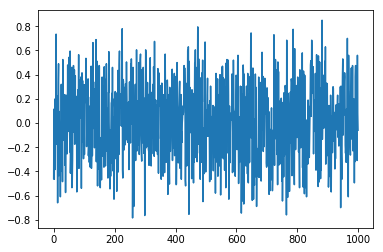

KeyboardInterrupt: 

In [32]:
#Estimate Correlations for number of MC steps
plt.plot(data.mean(1)[0:1000]);plt.show()

import estimate_correlations_ising
Xcorr = estimate_correlations_ising.spin_autocorr(data,n_max=int(Num_configs*0.01))
plt.plot(Xcorr);plt.show()

In [ ]:
plt.hist(data.mean(1),50);plt.show()

In [ ]:
plt.imshow(np.reshape(data[900,:],(size,size)),cmap='binary')

In [ ]:
#Train the model
RBM = rbm.RBM(visible = 'Spin', n_v=N, n_h = 2, hidden = 'Spin',zero_field = True)
results = RBM.fit(data,n_iter=100,verbose=0,learning_rate = 0.5,record=['W'],record_interval=1000,batch_size=20,N_MC= 20, lr_decay=False,batch_norm=False);

In [ ]:
# Reshape the weights array:
weights = np.zeros((np.shape(np.array(results['W']))[1],np.shape(np.array(results['W']))[0],size,size))
weights[0] = np.reshape(np.array(results['W'])[:,0,:],(np.shape(np.array(results['W']))[0],size,size),order='C')
weights[1] = np.reshape(np.array(results['W'])[:,1,:],(np.shape(np.array(results['W']))[0],size,size),order='C')

In [ ]:
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.contourf(weights[0,-1])
plt.colorbar()
plt.subplot(122)
plt.contourf(weights[1,-1])
plt.colorbar()

In [3]:
def ising2dCouplings(BM,size=20,beta1=0.39,beta2=0.39,PBC=False):
    
    BM.layer.couplings =  beta1*(np.eye(N=size**2,k=1) + np.eye(N=size**2,k=-1)) + beta2*(np.eye(N=size**2,k=size) + np.eye(N=size**2,k=-size))
    
    N = size
    
    if PBC is True:
        # Add the couplings of the first row to that of the last row and vice versa:
        for i in np.arange(0,N):
            BM.layer.couplings[i,(size**2)-N+i] = beta2
            BM.layer.couplings[(size**2)-N+i,i] = beta2
        # Remove the couplings of the left most coloumn to that of the last coloumn in its previous row:
        for i in np.arange(0,N*N,N):
            BM.layer.couplings[i,i-1] = 0
            BM.layer.couplings[i-1,i] = 0
        # Add the couplings of the left most column to the right most coloumn:
            BM.layer.couplings[i,i+N-1] = beta1
            BM.layer.couplings[i+N-1,i] = beta1
    
    return BM.layer.couplings